In [1]:
import numpy as np
import cv2 as cv
import skimage.filters as filters
from matplotlib import pyplot as plt

In [2]:
#Macros:
#To adjust, keep in mind (0,0) is the top corner, +x is to right, and +y is to the bottom. 
LEFT_BOUND = 250
RIGHT_BOUND = 650
UPPER_BOUND = 00

#Feature Matching: 
NUM_FEATURES = 500
NUM_MATCHES = 90

In [68]:
#Image IO:
def read_image(image_file):
    img = cv.imread(image_file)
    return cv.cvtColor(img, cv.COLOR_BGR2RGB)

def show_image(image, title):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 14))
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    ax.axis('off')
    return fig, ax

#Preprocessing:
def grayscale(image):
    HSV = cv.cvtColor(image, cv.COLOR_RGB2HSV)
    return HSV[:,:,2]

def crop(image):
    xmax = image.shape[0]
    return image[UPPER_BOUND:xmax, LEFT_BOUND:RIGHT_BOUND]

#Feature Detection:
def mark_features(image):
    image2 = image.copy()

    #ORB feature detection
    orb = cv.ORB_create(NUM_FEATURES)
    kp, des = orb.detectAndCompute(image2,None)
    for marker in kp:
	    image2 = cv.drawMarker(image2, tuple(int(i) for i in marker.pt), color=(0, 255, 0))
    return kp, des, image2

def match_features(kp1, des1, image1, kp2, des2, image2):
    #^keypoints, descriptors, and marked image respectively. Outputs of mark_features()
    #Feature Matching Algorithm, finds matches and selects the top ones:
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck = True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key = lambda x:x.distance)
    best_matches = matches[:NUM_MATCHES]

    #Get the points corresponding to the matches:
    p1 = []
    p2 = []
    for match in matches:
        p1.append(kp1[match.queryIdx].pt)   #points are stored in kp list. # old_kp
        p2.append(kp2[match.trainIdx].pt) #new_kp
    p1 = np.array(p1)
    p2 = np.array(p2)

    img3 = cv.drawMatches(image1, kp1, image2, kp2, best_matches, None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    return p1, p2, img3

def bg_color(img):
    # average color of row 0
    top_row = np.array([img[1]])
    average = np.mean(top_row, axis=(0,1))
    return average

# requires rgb image
# get n dominant colors using k-means clustering
def dominant_colors(img, n_colors):    
    pixels = np.float32(img.reshape(-1, 3))

    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 200, .1)
    flags = cv.KMEANS_RANDOM_CENTERS

    _, labels, palette = cv.kmeans(pixels, n_colors, None, criteria, 10, flags)
    _, counts = np.unique(labels, return_counts=True)

    return palette

#All-in-one alignment, simply pass in preprocessed images:
def align_images(source_img, dest_img) :
    #Get keypoints:
    source_points, dest_points, _ = match_features(*mark_features(source_img), *mark_features(dest_img))
    #Estimate Homography Transformation:
    homography, _ = cv.findHomography(source_points, dest_points, cv.RANSAC, 5.0)
    #Apply Homography Transformation:
    y, x = dest_img.shape[:2]
    transformed_img = cv.warpPerspective(source_img, homography, (x, y), borderValue=bg_color(source_img))  
    #^Warp perspective > perspective Transform
    return transformed_img

#Segmentation:
def subtract_background(image):
    processed = image.copy()
    background_threshold = filters.threshold_otsu(processed)
    processed[processed < background_threshold] = 0
    return processed

def segment(image, n=2):
    #OpenCV Boilerplate:
    buffer = np.float32(image.flatten())
    criteria = (cv.TERM_CRITERIA_EPS + cv.TermCriteria_MAX_ITER, 10, 1.0)
    ret, label, center = cv.kmeans(buffer, n, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    return center, res.reshape(image.shape)

#All-in-one segmentation:
def segment3(image): 
    processed = image.copy() 
    #Remove background noise for clustering
    processed = subtract_background(processed)
    #Cluster
    center, processed = segment(processed, 3)
    #Map three cluster colors to high contrast values: 30, 100, 200
    center = np.sort(center.flatten())
    processed = np.where(processed==center[0], 30, processed) 
    processed = np.where(processed==center[1], 100, processed) 
    processed = np.where(processed==center[2], 200, processed)
    return processed

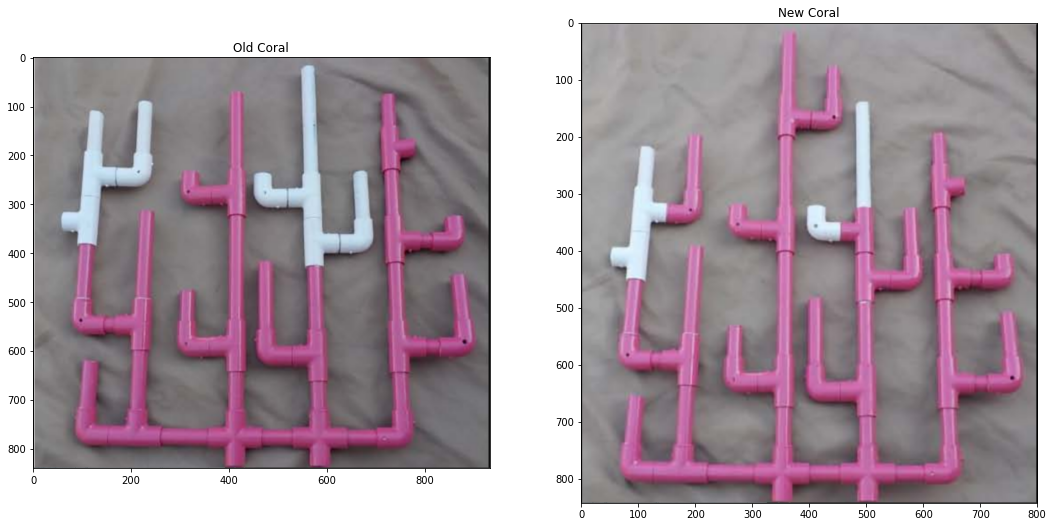

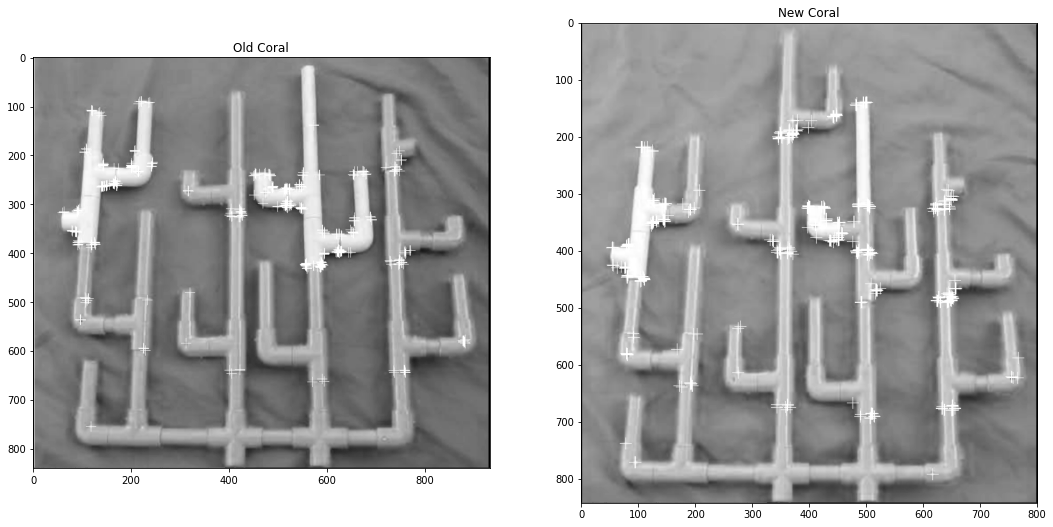

In [72]:
#Load Images:
oldCoral = read_image("old_coral.PNG")
newCoral = read_image("new_coral.PNG")

#Preprocessing, limited to grayscale:
# old_kp, old_des, old_processed = mark_features(grayscale(oldCoral))
# new_kp, new_des, new_processed = mark_features(grayscale(newCoral))
old_kp, old_des, old_processed = mark_features(oldCoral)
new_kp, new_des, new_processed = mark_features(newCoral)
old_processed = grayscale(old_processed)
new_processed = grayscale(new_processed)

fig, ax = plt.subplots(1, 2, figsize=(18, 40))
_ = ax[0].imshow(oldCoral)
_ = ax[0].set_title("Old Coral")
_ = ax[1].imshow(newCoral)
_ = ax[1].set_title("New Coral")

fig, ax = plt.subplots(1, 2, figsize=(18, 40))
_ = ax[0].imshow(old_processed, cmap='gray')
_ = ax[0].set_title("Old Coral")
_ = ax[1].imshow(new_processed, cmap='gray')
_ = ax[1].set_title("New Coral")

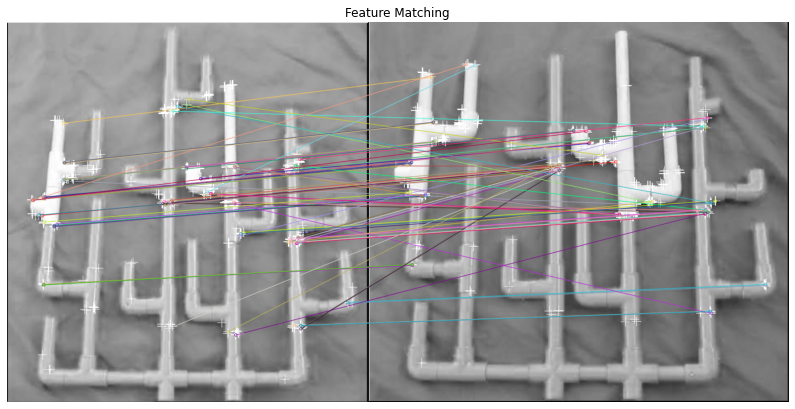

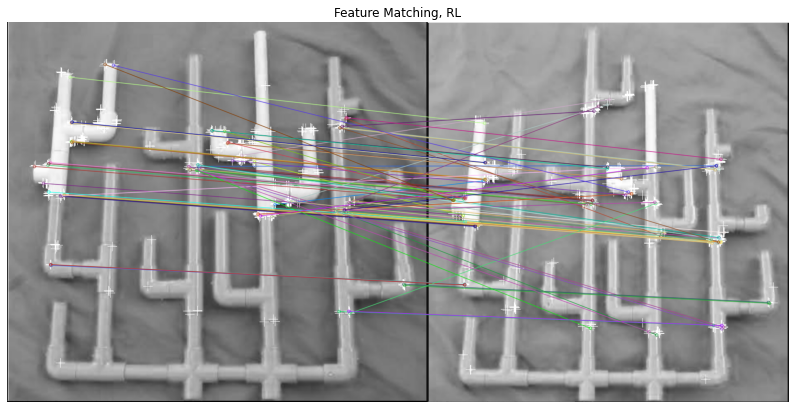

In [73]:
#Match Drawing:
p1, p2, img3 = match_features(new_kp, new_des, new_processed, old_kp, old_des, old_processed)
p3, p4, img4 = match_features(old_kp, old_des, old_processed, new_kp, new_des, new_processed)
_ = show_image(img3, "Feature Matching")
_ = show_image(img4, "Feature Matching, RL")

It's subtle, but for NUM_FEATURES = 500 and NUM_MATCHES = 90, look at the root. <br>
You will see a single cross. From LR, this feature is not used. For RL, it is used-- very incorrectly. <br>
This outlier match, and others, effect the homology in the next stage.

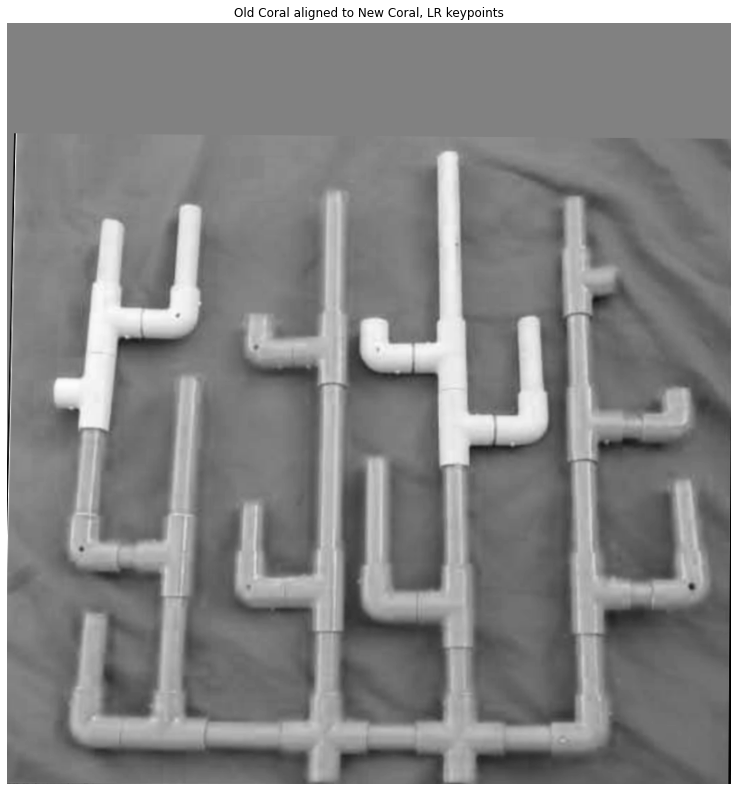

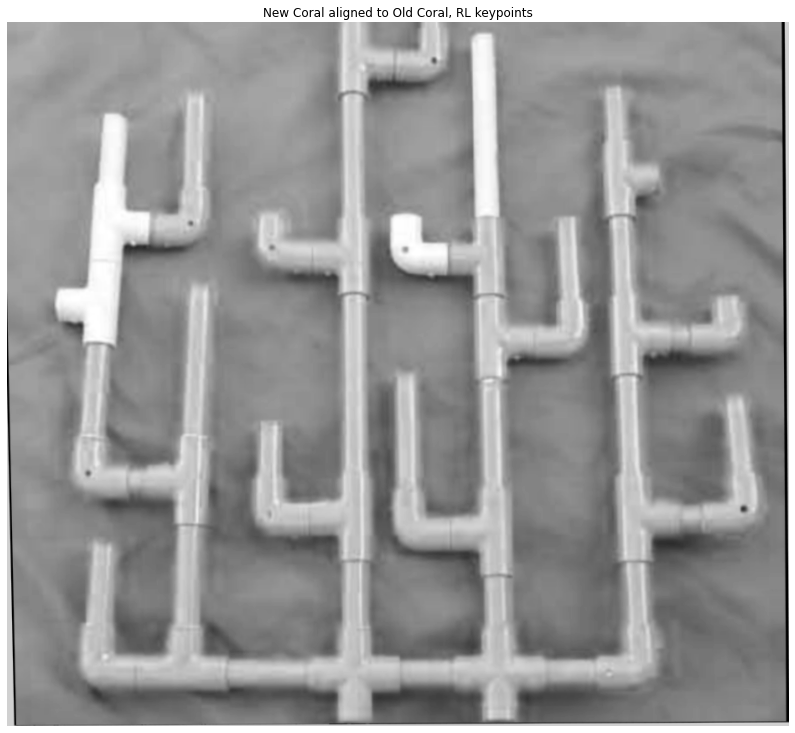

In [74]:
# alignedLeft = align_images(grayscale(oldCoral), grayscale(newCoral))
alignedLeft_color = align_images(oldCoral, newCoral)
alignedLeft = grayscale(alignedLeft_color)
_ = show_image(alignedLeft, "Old Coral aligned to New Coral, LR keypoints")

# alignedRight = align_images(grayscale(newCoral), grayscale(oldCoral))
alignedRight_color = align_images(newCoral, oldCoral)
alignedRight = grayscale(alignedRight_color)
_ = show_image(alignedRight, "New Coral aligned to Old Coral, RL keypoints")

Note about align_images: also checks which set of keypoints is more accurate. <br>
Align images matches keypoints according to the order of images. <br>
Left-to-right matches may be better than right-to-left for many features with similar measure of similarity. <br>
For these blackbox algorithms, simply need to try both approaches to see which works better. <br>

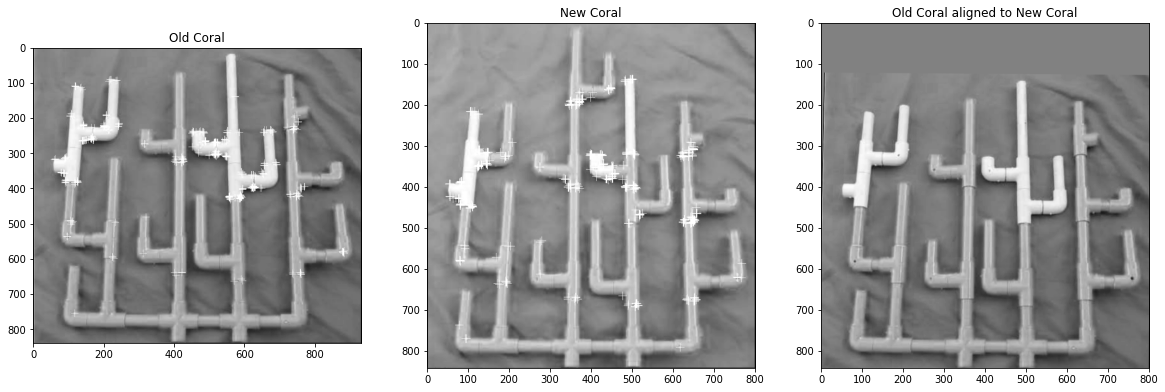

In [75]:
#Choosing the LR transformation for this particular case.
#Side by side plots:

fig, ax = plt.subplots(1, 3, figsize=(20, 8))
_ = ax[0].imshow(old_processed, cmap='gray')
_ = ax[0].set_title("Old Coral")
_ = ax[1].imshow(new_processed, cmap='gray')
_ = ax[1].set_title("New Coral")
_ = ax[2].imshow(alignedLeft, cmap='gray')
_ = ax[2].set_title("Old Coral aligned to New Coral")

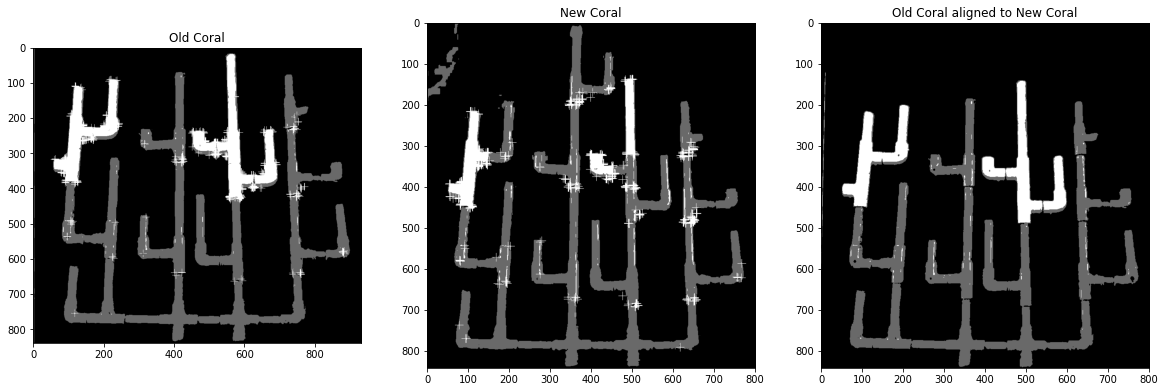

In [76]:
#Segmentation:
old_segmented = segment3(old_processed)
new_segmented = segment3(new_processed)
aligned_segmented = segment3(alignedLeft)

fig, ax = plt.subplots(1, 3, figsize=(20, 8))
_ = ax[0].imshow(old_segmented, cmap='gray')
_ = ax[0].set_title("Old Coral")
_ = ax[1].imshow(new_segmented, cmap='gray')
_ = ax[1].set_title("New Coral")
_ = ax[2].imshow(aligned_segmented, cmap='gray')
_ = ax[2].set_title("Old Coral aligned to New Coral")

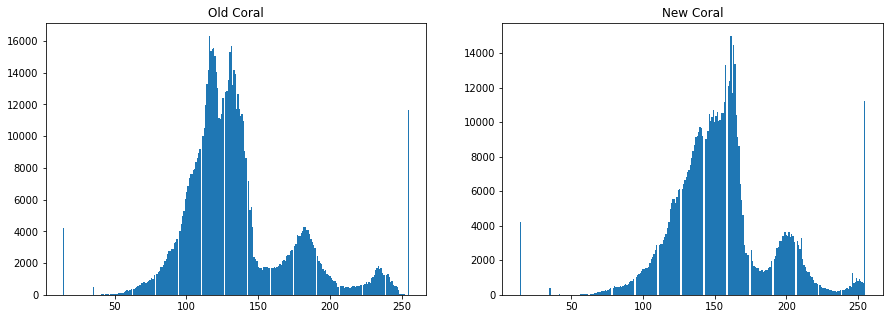

In [77]:
#Histograms:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
_ = ax[0].hist(old_processed.flatten(), 256)
_ = ax[0].set_title("Old Coral")
_ = ax[1].hist(new_processed.flatten(), 256)
_ = ax[1].set_title("New Coral")

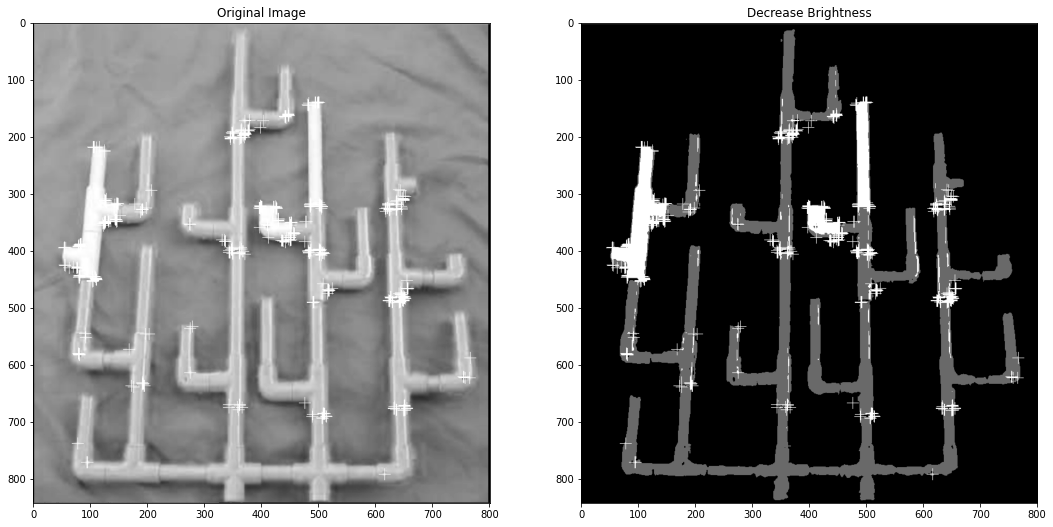

In [78]:
#Lets try decreasing brightness:
def adjust_contrast(image, a):
    #Enforce range of [0, 255]
    contrast_map = np.arange(0.0, 256.0) * float(a)
    above_255_indicies = contrast_map > 255
    below_0_indicies = contrast_map < 0
    contrast_map[above_255_indicies] = 255
    contrast_map[below_0_indicies] = 0

    #Apply Transformation
    processed = image.copy()
    xrange, yrange = image.shape
    for x in range(xrange) :
        for y in range(yrange) :
            processed[x][y] = contrast_map[processed[x][y]]
    return processed

def adjust_brightness(image, b):
    #Enforce range of [0, 255]
    brightness_map = np.arange(0.0, 256.0) + float(b)
    above_255_indicies = brightness_map > 255
    below_0_indicies = brightness_map < 0
    brightness_map[above_255_indicies] = 255
    brightness_map[below_0_indicies] = 0

    #Apply Transformation
    processed = image.copy()
    xrange, yrange = image.shape
    for x in range(xrange) :
        for y in range(yrange) :
            processed[x][y] = brightness_map[processed[x][y]]
    return processed

new_edited = adjust_brightness(new_processed, -150)

fig, ax = plt.subplots(1, 2, figsize=(18, 40))
_ = ax[0].imshow(new_processed, cmap='gray')
_ = ax[0].set_title("Original Image")
_ = ax[1].imshow(segment3(new_edited), cmap='gray')
_ = ax[1].set_title("Decrease Brightness")

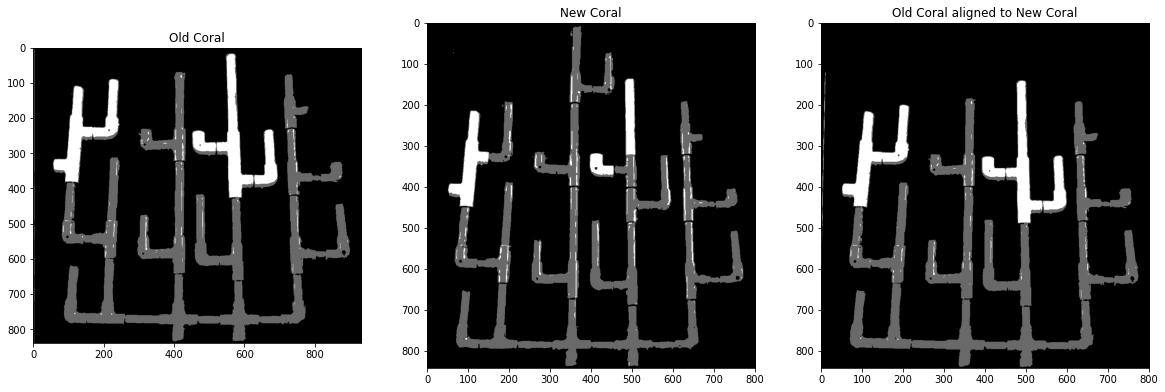

In [79]:
#Updated Segmentation:
old_segmented = segment3(grayscale(oldCoral))
new_segmented = segment3(adjust_brightness(grayscale(newCoral), -150))
aligned_segmented = segment3(alignedLeft)

fig, ax = plt.subplots(1, 3, figsize=(20, 8))
_ = ax[0].imshow(old_segmented, cmap='gray')
_ = ax[0].set_title("Old Coral")
_ = ax[1].imshow(new_segmented, cmap='gray')
_ = ax[1].set_title("New Coral")
_ = ax[2].imshow(aligned_segmented, cmap='gray')
_ = ax[2].set_title("Old Coral aligned to New Coral")

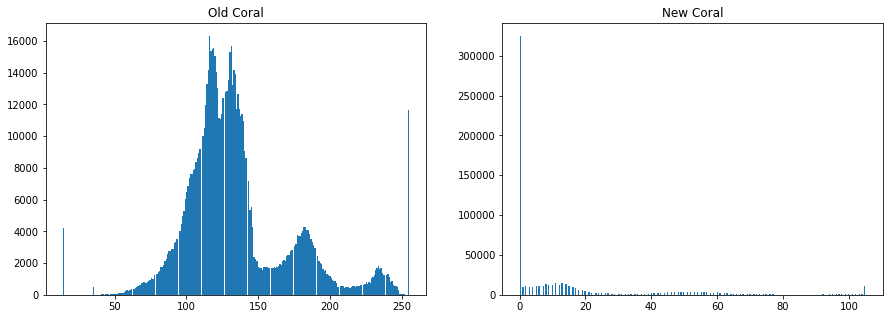

In [80]:
#Updated Histograms:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
_ = ax[0].hist(old_processed.flatten(), 256)
_ = ax[0].set_title("Old Coral")
_ = ax[1].hist(new_edited.flatten(), 256)
_ = ax[1].set_title("New Coral")

Decreasing the brightness appears to improve the segmentation by removing any noisy values that are a part of the background that are necessarily darker than the bright coral. For a brightly-lit pool, decreasing the brightness will be necessary for cleanly distinguishing pink, white, and background color.

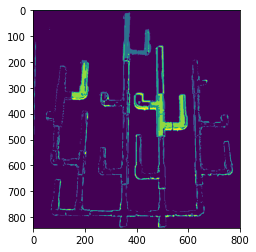

In [81]:
#Image Subtraction:
difference = np.abs(new_segmented - aligned_segmented)
_ = plt.imshow(difference)

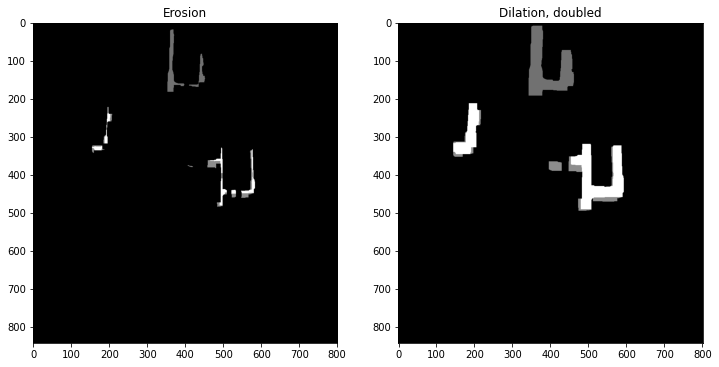

In [82]:
#Morphological Operation to Rid of Subtraction Noise:
kernel = np.ones((3,3),np.uint8)
erosion = cv.erode(difference,kernel,iterations = 5)
opened = cv.dilate(erosion,kernel,iterations = 10)

fig, ax = plt.subplots(1, 2, figsize=(12, 20))
_ = ax[0].imshow(erosion, cmap='gray')
_ = ax[0].set_title("Erosion")
_ = ax[1].imshow(opened, cmap='gray')
_ = ax[1].set_title("Dilation, doubled")

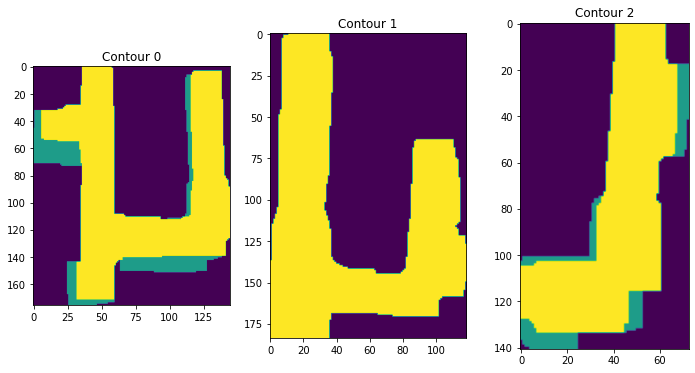

In [83]:
#Find contours. Contours: "a curve joining all the continuous points along a boundary having same color or intensity."
#Contours is a list of 2D numpy arrays containing boundary points. Contours are needed for drawing bounding box.
difference_image = opened
contours, _ = cv.findContours(opened, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

#Top <= 4 contours:
contours.sort(key=cv.contourArea, reverse=True)
contours = contours[:4]
#Filter out duds:
contours = [c for c in contours if cv.contourArea(c) > 1000] #~30x30 pixels

#Extracted Bounding Boxes:
fig, ax = plt.subplots(1, len(contours), figsize=(12, 6))
for i, c in zip(range(len(contours)), contours):
    x, y, w, h = cv.boundingRect(c)
    box = difference_image[y:y+h, x:x+w]
    ax[i].imshow(box)
    ax[i].set_title("Contour {}".format(i))

Contours are correctly extracted.

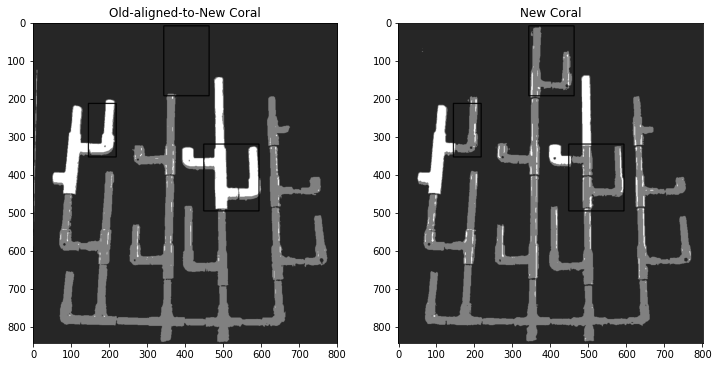

In [84]:
#Bounding Boxes drawn on new and old aligned to new images:
aligned_rect = aligned_segmented.copy()
new_rect = new_segmented.copy()

for c in contours:
    x, y, w, h = cv.boundingRect(c)
    cv.rectangle(aligned_rect, (x,y), (x+w, y+h), color=(0, 255, 0), thickness=2)
    cv.rectangle(new_rect, (x,y), (x+w, y+h), color=(0, 255, 0), thickness=2)

fig, ax = plt.subplots(1, 2, figsize=(12, 20))
_ = ax[0].imshow(aligned_rect, cmap='gray')
_ = ax[0].set_title("Old-aligned-to-New Coral")
_ = ax[1].imshow(new_rect, cmap='gray')
_ = ax[1].set_title("New Coral")

Mode of bounding box does not discriminate the bounding box type (Almost always yields zero). <br>
Instead, attempt to draw contours in aligned image within boundaries of identified boxes. <br>
Assuming algorithm is accurate to this point, bounding box drawn in aligned image should yield open space or definitive coral. <br>
Finally, use mean of contour to categorize bounding box class.


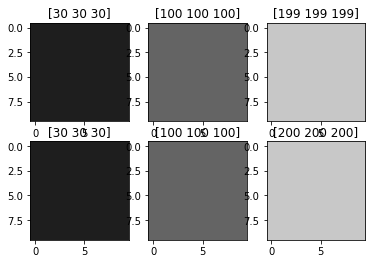

In [85]:
# get dominant colors
old_colors = dominant_colors(cv.cvtColor(aligned_segmented, cv.COLOR_GRAY2RGB), 3).astype(int)
new_colors = dominant_colors(cv.cvtColor(new_segmented, cv.COLOR_GRAY2RGB), 3).astype(int)
old_colors.sort(axis=0)
new_colors.sort(axis=0)
fig, ax = plt.subplots(2, 3)
for i, color in enumerate(old_colors):
    img = np.zeros([10,10,3], dtype=np.uint8)
    img[:,:] = color
    _ = ax[0][i].imshow(img, cmap='gray')
    _ = ax[0][i].set_title(color)
for i, color in enumerate(new_colors):
    img = np.zeros([10,10,3], dtype=np.uint8)
    img[:,:] = color
    _ = ax[1][i].imshow(img, cmap='gray')
    _ = ax[1][i].set_title(color)

(162.91588480052215, 0.0, 0.0, 0.0) (86.84098882271356, 0.0, 0.0, 0.0)
(30.65501766447054, 0.0, 0.0, 0.0) (80.29599923613101, 0.0, 0.0, 0.0)
(154.38056680161944, 0.0, 0.0, 0.0) (84.47975708502024, 0.0, 0.0, 0.0)


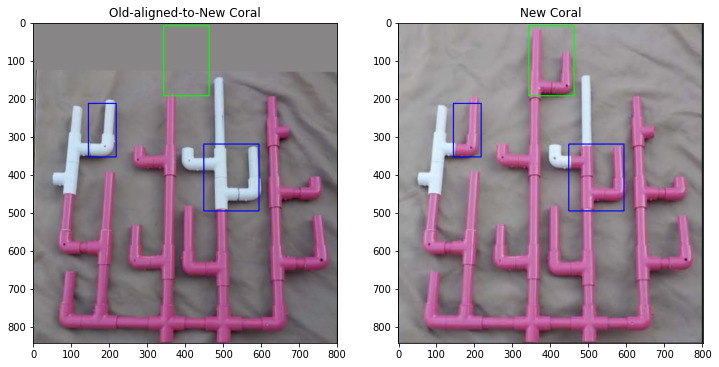

In [86]:
#Evaluate bounding box type, based on mean value of contours.
"""
Subtracting B,G,W from B,G,W
Cases: (double check the colors)
B-B, G-G, W-W will not yield any results.
-Growth: B -> G, green
-Damage: G -> B or W -> B, yellow
-Bleached: G -> W, red
-Recovered: W -> G, blue
"""

# color, colors assumed greyscale
# colors sorted from low to high (black, gray, white)
def color_label(color, colors):
    gray_colors = ['B', 'G', 'W']
    difference = [abs(c[0] - color[0]) for c in colors]
    return gray_colors[difference.index(min(difference))]

box_colors = {
    ('B', 'G'): (0, 255, 0), # Growth
    ('G', 'B'): (255, 255, 0), # Damage
    ('W', 'B'): (255, 255, 0),
    ('G', 'W'): (255, 0, 0), # Bleached
    ('W', 'G'): (0, 0, 255) # Recovered
}

def box_color(old_color, new_color):
    old_color_label = color_label(old_color, old_colors)
    new_color_label = color_label(new_color, new_colors)
    if (old_color_label, new_color_label) in box_colors:
        return box_colors[(old_color_label, new_color_label)]
    return (0, 0, 0)

#Bounding Boxes drawn on new and old aligned to new images:
oldCoral_rect = alignedLeft_color.copy()
newCoral_rect = newCoral.copy()

for i in range(len(contours)) :
    c = contours[i]
    #Reject small bounding boxes (this is ~30x30 box)
    if cv.contourArea(c) > 1000 :
        #Find highest frequency value in box
        x, y, w, h = cv.boundingRect(c)

        mask = np.zeros(opened.shape, np.uint8)
        cv.drawContours(mask, contours, i, 255, -1)
        
        old_color = cv.mean(aligned_segmented, mask=mask)
        new_color = cv.mean(new_segmented, mask=mask)
        print(old_color, new_color)
        border_color = box_color(old_color, new_color)

        cv.rectangle(oldCoral_rect, (x,y), (x+w, y+h), color=border_color, thickness=2)
        cv.rectangle(newCoral_rect, (x,y), (x+w, y+h), color=border_color, thickness=2)

fig, ax = plt.subplots(1, 2, figsize=(12, 20))
_ = ax[0].imshow(oldCoral_rect)
_ = ax[0].set_title("Old-aligned-to-New Coral")
_ = ax[1].imshow(newCoral_rect)
_ = ax[1].set_title("New Coral")


## Development Journal: <br>
Mapping trained on subset of image does not hold for the entire image! <br>

At a high level, aligning a part of the image should align the entire image. <br>
However, unfortunately, the feature matching algorithm is not crop invariant! <br>
That is, it will produce a different transformation for different images, even if the contents of the image are the same. <br>
-> Why is this? <br>
The corners the algorithm finds in each image are different. 
In theory, if the algorithm found all the corresponding corners the algorithm would find in the macthing the original pair,
the transformation would hold. However, it only takes one different match, to throw off the entire matrix, and the information contained in your subset will be different then your original.

Feature Matching is brittle.
- Do not apply any preprocessing prior to alignment. Keep all the information content for more accurate matches.
Therefore, do not crop and do not perform segmentation. Only after alignment perform segmentation. 
- Feature Matching is also dependent on the order of keypoint traversal. Iterating through keypoint list1 results in DIFFERENT matches than iterating through keypoint list2 for matches that have the same similarity metric. 

Segmentation is also brittle.
For absolutely clean segmentations, need to shape distribution into clearly defined, smooth peaks.
Segmentation does not work for objects not uniform in color or low contrast.

Bounding Box drawing is going well. <br>
Subtract the images, remove noise with morphological operations, drawing contours, then bounding boxes. <br>
Working on classiying the boxes. <br>
Going well so far, although image subtraction/contour drawing rely heavily on accuracy of homology and segmentation-- very important indeed! <br>

## Project Overview and Planning: 
Manual: https://files.materovcompetition.org/2021/2021_NAVIGATOR_Manual_14Sept2020.pdf

Updated Pipeline: <br>
Grayscale -> Feature Match -> Homology -> Segementation -> Image Subtraction <br>

Experimentally, feature matching is brittle. <br>
As noted by OpenCv, https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html: <br>
 "Fundamental Matrix estimation is sensitive to quality of matches, outliers etc. <br>
 It becomes worse when all selected matches lie on the same plane." <br>

Potential Enhacements: <br>
Better Feature Matching with HomologyNet: https://mez.github.io/2017/07/21/homographynet-deep-image-homography-estimation/ <br>
Better Image Segmentation with fastai: https://towardsdatascience.com/image-segmentation-with-fastai-9f8883cc5b53

## Lessons learned: <br>
- Always read documentation! <br>
Documentation has helpful examples of intended style/use, and will tell you in input/output types and what they mean. 
- Nueral Nets are more robust ????